## Vehicle Detection and Tracking Project

Vehicle detection in a video stream using image processing

## Load Packages

In [1]:
# Packages and libraries
import os
import sys
import cv2
import time
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Lines import Line
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

# Inline plotting 
%matplotlib inline

## Function library

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis = False, feature_vec = True):
    """Define a function to return HOG features and visualization"""
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                                  cells_per_block = (cell_per_block, cell_per_block), transform_sqrt = False, 
                                  visualise = vis, feature_vector = feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                       cells_per_block = (cell_per_block, cell_per_block), transform_sqrt = False,
                       visualise = vis, feature_vector = feature_vec)
        return features


def bin_spatial(img, size = (32, 32)):
    """Resizing"""
    #color1 = cv2.resize(img[:,:,0], size, interpolation = cv2.INTER_NEAREST).ravel()
    #color2 = cv2.resize(img[:,:,1], size, interpolation = cv2.INTER_NEAREST).ravel()
    #color3 = cv2.resize(img[:,:,2], size, interpolation = cv2.INTER_NEAREST).ravel()
    #color1 = cv2.resize(img[:,:,0], size).ravel()
    #color2 = cv2.resize(img[:,:,1], size).ravel()
    #color3 = cv2.resize(img[:,:,2], size).ravel()
    spatial = cv2.resize(img, size).ravel()
    #return np.hstack((color1, color2, color3))
    return spatial


def color_hist(img, nbins = 32):
    """Define a function to compute color histogram features"""
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins = nbins)
    channel2_hist = np.histogram(img[:,:,1], bins = nbins)
    channel3_hist = np.histogram(img[:,:,2], bins = nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms
    return hist_features


def extract_features(imgs, cspace = 'RGB', spatial_size = (32, 32), hist_bins = 32, orient = 9,
                     pix_per_cell = 8, cell_per_block = 2, hog_channel = 0, spatial_feat = True,
                     hist_feat = True, hog_feat = True):
    """Function that extract features from images"""
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'       
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size = spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins = hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
            # Call get_hog_features()
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,
                                                         cell_per_block, vis = False, feature_vec = False))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell,
                                                cell_per_block, vis = False, feature_vec = False)
            file_features.append(hog_features)
        
        # Update main feature list by 1-D file features
        features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return features


def slide_window(img, x_start_stop = [None, None], y_start_stop = [None, None], xy_window = (64, 64),
                 xy_overlap = (0.5, 0.5)):
    """Function that returns sliding window positions"""
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1] #columns
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0] #rows
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list


def draw_boxes(img, bboxes, color = (0, 0, 255), thick = 6):
    """Define a function to draw bounding boxes"""
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy


def single_img_features(img, cspace = 'RGB', spatial_size = (32, 32), hist_bins = 32, orient = 9,
                        pix_per_cell = 8, cell_per_block = 2, hog_channel = 0, spatial_feat = True,
                        hist_feat = True, hog_feat = True, vis = False):
    """Define a function to extract features from a single image window"""
    
    # Create a list to append feature vectors to
    img_features = []
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
    if spatial_feat == True:
        # Get binned spatial features and update file_feature list
        spatial_features = bin_spatial(feature_image, size = spatial_size)
        img_features.append(spatial_features)
    
    if hist_feat == True:
        # Get color histogram featueres and update file_feature list
        hist_features = color_hist(feature_image, nbins = hist_bins)
        img_features.append(hist_features)
    
    if hog_feat == True:
        # Get HOG features for desired channels and update file_feature list
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,
                                                     cell_per_block, vis = False, feature_vec = True))
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell,
                                                           cell_per_block, vis = True, feature_vec = True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell,
                                                cell_per_block, vis = False, feature_vec = True)
        img_features.append(hog_features)
    
    # Return concatenate array features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


def search_windows(img, windows, clf, scaler, cspace = 'RGB', spatial_size = (32, 32), hist_bins = 32,
                   orient = 9, pix_per_cell = 8, cell_per_block = 2, hog_channel = 0,
                   spatial_feat = True, hist_feat = True, hog_feat = True):
    """Define a funtion you will pass an image and the list of windows to be searched"""
    
    # List for positive detecion windows - there is a car
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        #test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), interpolation = cv2.INTER_NEAREST)
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace = cspace, spatial_size = spatial_size,
                                       hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                                       cell_per_block = cell_per_block, hog_channel = hog_channel,
                                       spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    # Return windows for positive detections
    return on_windows


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels wi+th each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img


def find_cars(img, scale, clf, scaler, x_start_stop = [None, None], y_start_stop = [None, None],
              orient = 9, pix_per_cell = 8, cell_per_block = 2, spatial_size = (32, 32), hist_bins = 32):
    """Define a single function that can extract features using hog sub-sampling and make predictions"""
    
    img_boxes = []
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32) / 255
    
    ## Using desired start/stop positions we can reduce the image size that needs to be searched
    #if x_start_stop[0] == None:
    #    x_start_stop[0] = 0
    #if x_start_stop[1] == None:
    #    x_start_stop[1] = img.shape[1]
    #if y_start_stop[0] == None:
    #    y_start_stop[0] = 0
    #if y_start_stop[1] == None:
    #    y_start_stop[1] = img.shape[0]
    #
    #img_tosearch = img[y_start_stop[0]:y_start_stop[1], x_start_stop[0]:x_start_stop[1], :]
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, feature_vec = False)
    
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size = spatial_size)
            hist_features = color_hist(subimg, nbins = hist_bins)
            
            # Scale features and make a prediction
            test_features = x_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = x_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw + y_start_stop[0]), (xbox_left + win_draw,
                                        ytop_draw + win_draw + y_start_stop[0]), (0, 0, 255), 6) 
                img_boxes.append(((xbox_left, ytop_draw + y_start_stop[0]),
                                  (xbox_left + win_draw, ytop_draw + win_draw + y_start_stop[0])))
                heatmap[ytop_draw + y_start_stop[0]:ytop_draw + win_draw + y_start_stop[0],
                        xbox_left:xbox_left + win_draw] += 1
    
    return draw_img, heatmap, img_boxes, count


def visual(fig, rows, cols, imgs, titles):
    """Define a funtion for plotting multiple images"""
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(i + 1)
        img_dim = len(img.shape)
        if img_dim < 3:
            plt.imshow(img, cmap = 'hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


##Line Detection
def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):
    """Function that applies Sobel in x or y with a given kernel size takes the absolute value of
    the gradient scales to 8bit and returns a mask after checking values with the threshold range"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if orient.upper() == 'X':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    elif orient.upper() == 'Y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    else:
        sys.exit('Orientation should be a member of (x, y) in abs_sobel_thresh function')
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


def mag_thresh(img, sobel_kernel = 3, thresh = (0, 255)):
    """Calculates the derivatives in x and y directions with a given kernel size
    Uses the resultant magnitude of the derivatives to mask the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    
    scale_factor = np.max(sobel) / 255
    gradmag = (sobel / scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary_output


def dir_threshold(img, sobel_kernel = 3, thresh = (0, np.pi / 2)):
    """Calculates the derivatives in x and y directions with a given kernel size
    Then calculates the direction of the resultant vector formed by the x and y gradients
    Uses this direction information and threshold values provided to mask the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return binary_output


def hls_select(img, chn, thresh = (0, 255)):
    """Function that converts to HLS color space
    Applies a threshold to the desired channel and returns the mask"""
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    if chn.upper() == 'H':
        chn_select = hls[:, :, 0]
    elif chn.upper() == "L":
        chn_select = hls[:, :, 1]
    elif chn.upper() == "S":
        chn_select = hls[:, :, 2]
    else:
        sys.exit('Select from (H, L, S) as the channel argument for hls_select() function')
    
    binary_output = np.zeros_like(chn_select)
    binary_output[(chn_select >= thresh[0]) & (chn_select <= thresh[1])] = 1
    return binary_output


def hsv_select(img, chn, thresh = (0, 255)):
    """Function that converts to HSV color space
    Applies a threshold to the desired channel and returns the mask"""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    if chn.upper() == 'H':
        chn_select = hsv[:, :, 0]
    elif chn.upper() == "S":
        chn_select = hsv[:, :, 1]
    elif chn.upper() == "V":
        chn_select = hsv[:, :, 2]
    else:
        sys.exit('Select from (H, S, V) as the channel argument for hsv_select() function')
    
    binary_output = np.zeros_like(chn_select)
    binary_output[(chn_select >= thresh[0]) & (chn_select <= thresh[1])] = 1
    return binary_output


def window_mask(width, height, img_ref, center, level):
    """Draws boxes"""
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level + 1) * height):int(img_ref.shape[0] - level * height), max(0, int(center - width / 2)):min(int(center + width / 2), img_ref.shape[1])] = 1
    return output


def pipeline(img):
    # Get the calibration parameters
    calibrations_pickle = pickle.load(open('calibrations.p', 'rb'))
    mtx = calibrations_pickle['mtx']
    dist = calibrations_pickle['dist']
    
    # Undistort the image based on calibration data
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Apply some thresholding methods
    gradx = abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (15, 255))
    grady = abs_sobel_thresh(img, orient = 'y', sobel_kernel = 3, thresh = (45, 255))
     
    #mag_binary = mag_thresh(img, sobel_kernel = 3, thresh = (30, 100))
    #dir_binary = dir_threshold(img, sobel_kernel = 15, thresh = (0.7, 1.3))
    
    sthresh = hls_select(img, 's', thresh = (102, 255))
    vthresh = hsv_select(img, 'v', thresh = (51, 255))
    
    # Get the combined binary
    combined = np.zeros_like(gradx)
    combined[(gradx == 1) & (grady == 1) | ((sthresh == 1) & (vthresh == 1))] = 255
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    box_width = 0.645
    mid_width = 0.118
    height_pct = 0.645 #468px=,65; 450px=,625, 486px=,675
    bottom_trim = 0.934
    
    src = np.float32([[img.shape[1] * (.5 - mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (.5 + mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (.5 + box_width / 2), img.shape[0] * bottom_trim],
                      [img.shape[1] * (.5 - box_width / 2), img.shape[0] * bottom_trim]])
    
    # Offset adjusts the shrinkage of the warped image - larger is shrunken more
    offset = img.shape[1] * 0.175
    
    dst = np.float32([[offset, 0], [img.shape[1] - offset, 0],
                      [img.shape[1] - offset, img.shape[0]],
                      [offset, img.shape[0]]])
    
    # Get perspective transformation matrix and its inverse for later use
    mat = cv2.getPerspectiveTransform(src, dst)
    mat_inv = cv2.getPerspectiveTransform(dst, src)
    
    # Use the matrix for perspective transform
    binary_warped = cv2.warpPerspective(combined, mat, (img.shape[1], img.shape[0]), flags = cv2.INTER_LINEAR)
    
    # Window settings
    window_width = 30  # Window width
    window_height = 120  # Break image into 6 vertical layers since image height is 720
    margin = 30  # How much to slide left and right for searching
    smoothing_factor = 20  # Use last 20 results for averaging - smooth the data 20
    # The lane is about 30 meters long and 3.7 meters wide
    y_scale = 30.0 / 720.0  # 30 Meters is around 720 pixels
    x_scale = 3.7 / 700.0  # 3.7 Meters is around 700 pixels
    
    # Setup the overall class to do all the tracking
    centroids = Line(window_width = window_width, window_height = window_height, margin = margin, ym = y_scale, xm = x_scale, smooth_factor = smoothing_factor)
    
    window_centroids = centroids.find_window_centroids(binary_warped)
    
    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)
        
        # Points used to find the left and right lanes
        rightx = []
        leftx = []
        
        # Go through each level and draw the windows
        for level in range(0, len(window_centroids)):
            # Add center value found in frame to the list of lane points per left, right
            leftx.append(window_centroids[level][0])
            rightx.append(window_centroids[level][1])
            
            # Function to draw window areas
            l_mask = window_mask(window_width, window_height, binary_warped, window_centroids[level][0], level) #window_width - 35
            r_mask = window_mask(window_width, window_height, binary_warped, window_centroids[level][1], level) #window_width - 35
            
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | ((l_mask == 1))] = 255
            r_points[(r_points == 255) | ((r_mask == 1))] = 255
        
        # Draw the results
        # Add both left and right window pixels together
        template = np.array(r_points + l_points, np.uint8)
        zero_channel = np.zeros_like(template)
        # Make window pixels green
        template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
        # Making the original road pixels 3 color channel
        warpage = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)), np.uint8)
        # Overlay the original road image with window results
        output = cv2.addWeighted(warpage, 1.0, template, 0.5, 0.0)
        
        # Fit the lane boundaries to the left, right and center positions found
        yvals = range(0, binary_warped.shape[0])
        
        # Box centers
        res_yvals = np.arange(binary_warped.shape[0] - (window_height / 2), 0, -window_height)
        
        # Fit polynomial to left - 2nd order
        left_fit = np.polyfit(res_yvals, leftx, 2)
        # Predict the x value for each y value - continuous with resolution of 1 pixel
        left_fitx = left_fit[0] * yvals * yvals + left_fit[1] * yvals + left_fit[2]
        left_fitx = np.array(left_fitx, np.int32)
        
        # Fit polynomial to right - 2nd order
        right_fit = np.polyfit(res_yvals, rightx, 2)
        # Predict the x value for each y value - continuous with resolution of 1 pixel
        right_fitx = right_fit[0] * yvals * yvals + right_fit[1] * yvals + right_fit[2]
        right_fitx = np.array(right_fitx, np.int32)
        
        # Left lane
        left_lane = np.array(list(zip(np.concatenate((left_fitx - (window_width) / 2, left_fitx[::-1] + (window_width) / 2), axis = 0),
                                      np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32) #window_width - 35
        # Right lane
        right_lane = np.array(list(zip(np.concatenate((right_fitx - (window_width) / 2, right_fitx[::-1] + (window_width) / 2), axis = 0),
                                       np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32) #window_width - 35
        
        # Inner lane
        inner_lane = np.array(list(zip(np.concatenate((left_fitx + (window_width) / 2, right_fitx[::-1] - (window_width) / 2), axis = 0),
                                       np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32) #window_width - 35
        
        # Lane lines themselves
        road = np.zeros_like(img)
        cv2.fillPoly(road, [left_lane], color = [255, 0, 0, 0.35])
        cv2.fillPoly(road, [right_lane], color = [0, 0, 255, 0.35])
        cv2.fillPoly(road, [inner_lane], color = [0, 255, 0, 0.35])
        # Inverse transform to get back to actual perspective
        road_warped = cv2.warpPerspective(road, mat_inv, (img.shape[1], img.shape[0]), flags = cv2.INTER_LINEAR)
        
        ## Then add the lane lines
        result = cv2.addWeighted(img, 1.0, road_warped, 0.7, 0.0)
        output = result
        
        # Meters per pixel in y direction
        xm_ppx, ym_ppx = centroids.get_ppx_values()
        
        # Fit a 2nd order polynomial for the actual x and y coordinates of the left lane
        # Left lane is more stable
        curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32) * ym_ppx, np.array(leftx, np.float32) * xm_ppx, 2)
        # Using the formula calculate the road curvature
        curverad = ((1 + (2 * curve_fit_cr[0] * yvals[-1] * ym_ppx + curve_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * curve_fit_cr[0])
        
        # Calculate the offset of the car on the road
        # Average the x pixel values that are closest to the car to find the road center
        road_center = (left_fitx[-1] + right_fitx[-1]) / 2
        # Find the difference between the road center and the warped image center - convert it to actual meters
        center_diff = (road_center - binary_warped.shape[1]/2) * xm_ppx
        side_pos = "left"
        if center_diff <= 0:
            # if difference is smaller than zero, warped image center (and hence the car) location is to the right of the road
            side_pos = "right"
        
        # Draw the text showing curvature and offset
        cv2.putText(output, 'Curvature = ' + str(round(curverad, 3)) + '(m)', (40, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(output, 'Position = ' + str(abs(round(center_diff, 3))) + 'm ' + side_pos + ' of center', (640, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
    else:
        output = img
    
    return output


def main_process(img):
    # Read in image similar to one shown above 
    #heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    out_img, heatmap, img_boxes, count = find_cars(img = img, scale = scale, clf = svc, scaler = x_scaler,
                                                   x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                                                   orient = orient, pix_per_cell = pix_per_cell, 
                                                   cell_per_block = cell_per_block, spatial_size = spatial_size,
                                                   hist_bins = hist_bins)
    # Add heat to each box in box list
    #heat = add_heat(heat, img_boxes)
    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat, 1)
    heat = apply_threshold(heatmap, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img


def challenge(img):
    # Advanced Line Detection
    out_img_pipe = pipeline(img = img)
    
    # Read in image similar to one shown above 
    #heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    out_img, heatmap, img_boxes, count = find_cars(img = img, scale = scale, clf = svc, scaler = x_scaler,
                                                   x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                                                   orient = orient, pix_per_cell = pix_per_cell, 
                                                   cell_per_block = cell_per_block, spatial_size = spatial_size,
                                                   hist_bins = hist_bins)
    # Add heat to each box in box list
    #heat = add_heat(heat, img_boxes)
    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat, 1)
    heat = apply_threshold(heatmap, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(out_img_pipe), labels)
    
    return draw_img


def video_processing(input_path, output_path, process):
    # A function to process video images
    clip = VideoFileClip(input_path)
    video_clip = clip.fl_image(process)
    %time video_clip.write_videofile(output_path, audio = False)

## Parameters

In [3]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
cspace = 'YCrCb' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 1  # Can be 0, 1, 2, or 'ALL'
spatial_size = (64, 64)  # Dimensions
hist_bins = 64  # Number of histograms
spatial_feat = True  # True/False
hist_feat = True  # True/False
hog_feat = True  # True/False
#hist_range = (0, 256)

x_start_stop = [None, None]
y_start_stop = [400, 672]#672
scale = 1.5
overlap = 0.5
n_samples = 2000

## Load Images, data visualization and training Classifier

There is a count of 8792 vehicles and 8968 non-vehicles of size: (64, 64, 3) and data type: float32 

112.31 Seconds to compute the features.

Using: 9 orientations 8 pixels per cell and 2 cells per block 64 histogram bins, and (64, 64) spatial sampling

Feature vector length: 17772 

43.37 Seconds to train SVC.
Test accuracy of SVC = 0.9875


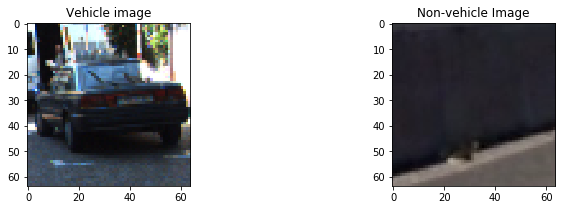

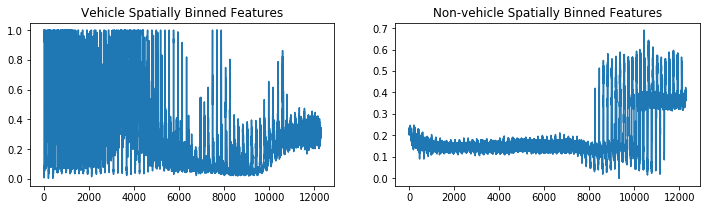

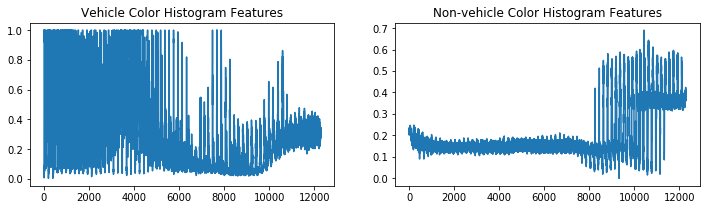

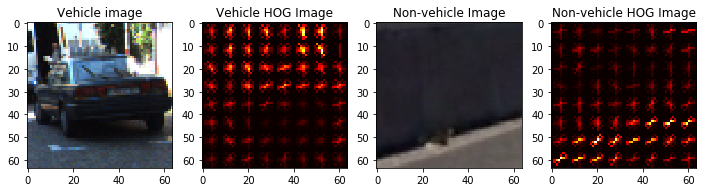

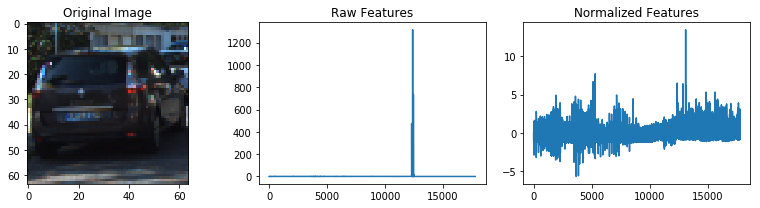

In [4]:
#Packaging of images of vehicles and non-vehicles
pack_vehicles = glob.glob('vehicles/*/*.png')
pack_nonvehicles = glob.glob('non-vehicles/*/*.png')
test_images = glob.glob('test_images/test*.jpg')

example_img = mpimg.imread('non-vehicles/Extras/extra1.png')

print('There is a count of', len(pack_vehicles), 'vehicles and', len(pack_nonvehicles), 'non-vehicles',
      'of size:', example_img.shape, 'and data type:', example_img.dtype, '\n')

# Just for fun choose random vehicles / not-vehicles indices   
vehicles_ind = np.random.randint(0, len(pack_vehicles))
nonvehicles_ind = np.random.randint(0, len(pack_nonvehicles))

# Read in car / not-car images
vehicle_image = mpimg.imread(pack_vehicles[vehicles_ind])
nonvehicle_image = mpimg.imread(pack_nonvehicles[nonvehicles_ind])

# Plot the examples
images = [vehicle_image, nonvehicle_image]
titles = ['Vehicle image', 'Non-vehicle Image']
fig = plt.figure(figsize = (12, 3))
visual(fig, 1, 2, images, titles)
plt.savefig('output_images/vehicle_nonvehicle_img.jpg')


# Spatial binnning
vehicle_binning = bin_spatial(vehicle_image, spatial_size)
nonvehicle_binning = bin_spatial(nonvehicle_image, spatial_size)

# Plot features
fig = plt.figure(figsize = (12, 3))
plt.subplot(121)
plt.plot(vehicle_binning)
plt.title('Vehicle Spatially Binned Features')
plt.subplot(122)
plt.plot(nonvehicle_binning)
plt.title('Non-vehicle Spatially Binned Features')
plt.savefig('output_images/spatial-binned_img.jpg')


#color histogram
vehicle_color_hist = color_hist(vehicle_image, hist_bins)
nonvehicle_color_hist = color_hist(nonvehicle_image, hist_bins)

# Plot features
fig = plt.figure(figsize = (12, 3))
plt.subplot(121)
plt.plot(vehicle_binning)
plt.title('Vehicle Color Histogram Features')
plt.subplot(122)
plt.plot(nonvehicle_binning)
plt.title('Non-vehicle Color Histogram Features')
plt.savefig('output_images/color-histogram_img.jpg')


vehicle_features, vehicle_hog_image = single_img_features(vehicle_image, cspace = cspace,
                                                          spatial_size = spatial_size, hist_bins = hist_bins,
                                                          orient = orient, pix_per_cell = pix_per_cell,
                                                          cell_per_block = cell_per_block, hog_channel = hog_channel,
                                                          spatial_feat = spatial_feat, hist_feat = hist_feat,
                                                          hog_feat = hog_feat, vis = True)

nonvehicle_features, nonvehicle_hog_image = single_img_features(nonvehicle_image, cspace = cspace,
                                                                spatial_size = spatial_size, hist_bins = hist_bins,
                                                                orient = orient, pix_per_cell = pix_per_cell,
                                                                cell_per_block = cell_per_block, hog_channel = hog_channel,
                                                                spatial_feat = spatial_feat, hist_feat = hist_feat,
                                                                hog_feat = hog_feat, vis = True)

# Plot the examples
images = [vehicle_image, vehicle_hog_image, nonvehicle_image, nonvehicle_hog_image]
titles = ['Vehicle image', 'Vehicle HOG Image', 'Non-vehicle Image', 'Non-vehicle HOG Image']
fig = plt.figure(figsize = (12, 3))
visual(fig, 1, 4, images, titles)
plt.savefig('output_images/hog_img.jpg')


hog_channel = 'ALL'
t = time.time()

random_idxs = np.random.randint(0, len(pack_vehicles), n_samples)
test_vehicles = np.array(pack_vehicles)[random_idxs]
test_nonvehicles = np.array(pack_nonvehicles)[random_idxs]

vehicles_features = extract_features(test_vehicles, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,
                                     orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                     hog_channel = hog_channel, spatial_feat = spatial_feat, hist_feat = hist_feat,
                                     hog_feat = hog_feat)

nonvehicles_features = extract_features(test_nonvehicles, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,
                                        orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                        hog_channel = hog_channel, spatial_feat = spatial_feat, hist_feat = hist_feat,
                                        hog_feat = hog_feat)

print(round(time.time() - t, 2), 'Seconds to compute the features.\n')

x = np.vstack((vehicles_features, nonvehicles_features)).astype(np.float64)
# Fit a per-column scaler
x_scaler = StandardScaler().fit(x)
# Apply a per-column scaler
scaled_x = x_scaler.transform(x)
# Define the labels vector
y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(nonvehicles_features))))

# Plot the examples
vehicle_image = mpimg.imread(pack_vehicles[random_idxs[0]])
fig = plt.figure(figsize = (11, 3))
plt.subplot(131)
plt.imshow(mpimg.imread(pack_vehicles[random_idxs[0]]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(x[0])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_x[0])
plt.title('Normalized Features')
fig.tight_layout()
plt.savefig('output_images/features_img.jpg')


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.1, random_state = rand_state)

print('Using:',orient, 'orientations',pix_per_cell, 'pixels per cell and', 
      cell_per_block, 'cells per block', hist_bins, 'histogram bins, and',
      spatial_size, 'spatial sampling\n')
print('Feature vector length:', len(x_train[0]), '\n')

# Use linear SVC
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(x_train, y_train)
print(round(time.time() - t, 2), 'Seconds to train SVC.')
# Check the score of the SVC
print('Test accuracy of SVC =', round(svc.score(x_test, y_test), 4))

## Locating vehicles and drawing boxes

7.92 Seconds to process 1 image searching 1241 windows
8.2 Seconds to process 2 image searching 1241 windows
8.06 Seconds to process 3 image searching 1241 windows
8.08 Seconds to process 4 image searching 1241 windows
7.96 Seconds to process 5 image searching 1241 windows
7.9 Seconds to process 6 image searching 1241 windows


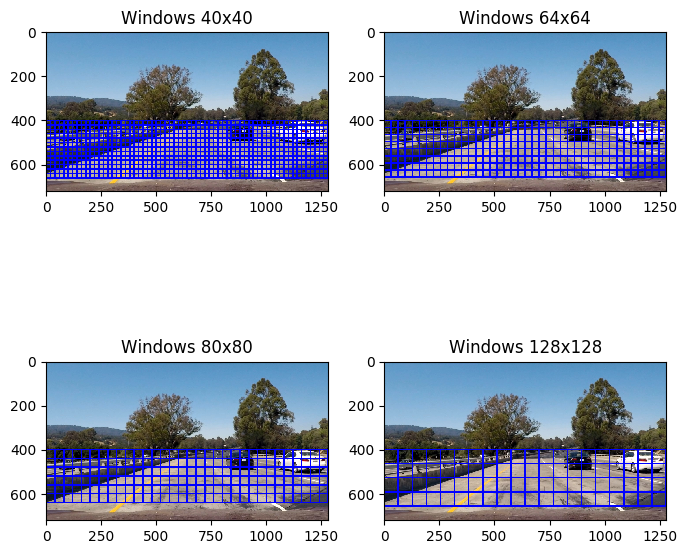

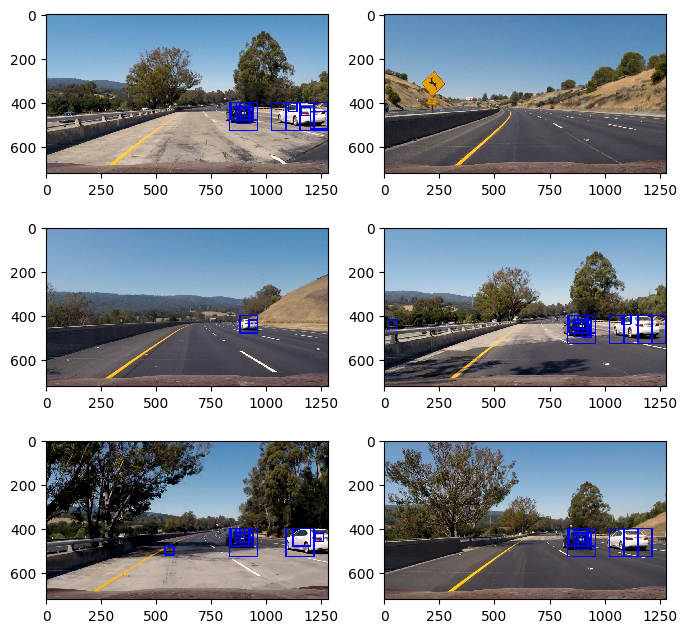

In [5]:
images = []
titles = []
img = mpimg.imread(test_images[0])
img_cop = np.copy(img)
draw_img = np.copy(img)
img = img.astype(np.float32) / 255
windows0 = slide_window(img, x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                        xy_window = (40, 40), xy_overlap = (overlap, overlap))
window_img = draw_boxes(draw_img, windows0, color = (0, 0, 255), thick = 6)
images.append(window_img)
titles.append('Windows 40x40')

draw_img = np.copy(img_cop)
img = img.astype(np.float32) / 255
windows1 = slide_window(img, x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                        xy_window = (64, 64), xy_overlap = (overlap, overlap))
window_img = draw_boxes(draw_img, windows1, color = (0, 0, 255), thick = 6)
images.append(window_img)
titles.append('Windows 64x64')

draw_img = np.copy(img_cop)
windows2 = slide_window(img, x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                        xy_window = (80, 80), xy_overlap = (overlap, overlap))
window_img = draw_boxes(draw_img, windows2, color = (0, 0, 255), thick = 6)
images.append(window_img)
titles.append('Windows 80x80')

draw_img = np.copy(img_cop)
windows3 = slide_window(img, x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                        xy_window = (128, 128), xy_overlap = (overlap, overlap))
window_img = draw_boxes(draw_img, windows3, color = (0, 0, 255), thick = 6)
images.append(window_img)
titles.append('Windows 128x128')
fig = plt.figure(figsize = (8, 8), dpi = 100)
visual(fig, 2, 2, images, titles)
plt.savefig('output_images/windowsX-X_img.jpg')



images = []
titles = []

count = 0
for img_src in test_images:
    count += 1
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    #print(np.min(img), np.max(img))
    
    windows0 = slide_window(img, x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                            xy_window = (40, 40), xy_overlap = (overlap, overlap))
    
    windows1 = slide_window(img, x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                            xy_window = (64, 64), xy_overlap = (overlap, overlap))
    
    windows2 = slide_window(img, x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                            xy_window = (80, 80), xy_overlap = (overlap, overlap))
    
    windows3 = slide_window(img, x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                            xy_window = (128, 128), xy_overlap = (overlap, overlap))
    
    windows = windows0 + windows1 + windows2 + windows3
    
    hot_windows = search_windows(img, windows, svc, x_scaler, cspace = cspace,
                                 spatial_size = spatial_size, hist_bins = hist_bins,
                                 orient = orient, pix_per_cell = pix_per_cell,
                                 cell_per_block = cell_per_block, hog_channel = hog_channel,
                                 spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color = (0, 0, 255), thick = 6)
    images.append(window_img)
    titles.append('')
    print(round(time.time() - t1, 2), 'Seconds to process', count, 'image searching', len(windows), 'windows')

fig = plt.figure(figsize = (8, 8), dpi = 100)
visual(fig, 3, 2, images, titles)
plt.savefig('output_images/windows_img.jpg')

## Heat areas

1.15 Seconds to run, total windows =  343
0.66 Seconds to run, total windows =  343
0.65 Seconds to run, total windows =  343
0.71 Seconds to run, total windows =  343
0.64 Seconds to run, total windows =  343
0.64 Seconds to run, total windows =  343


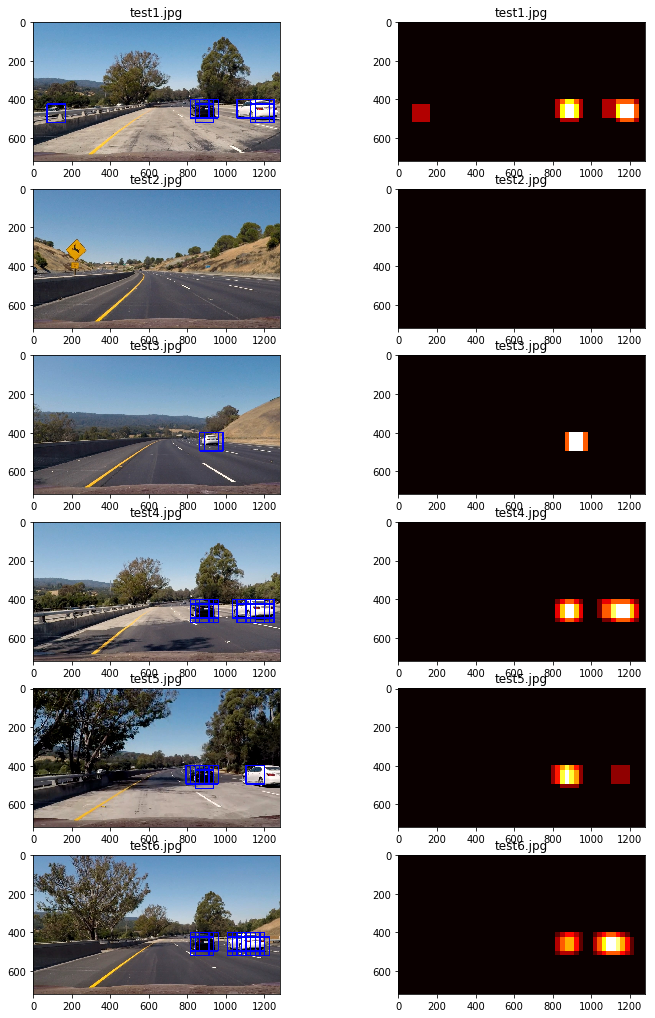

In [6]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

for img_src in test_images:
    t = time.time()
    img = mpimg.imread(img_src)
    
    draw_img, heatmap, img_boxes, count = find_cars(img = img, scale = scale, clf = svc, scaler = x_scaler,
                                                    x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                                                    orient = orient, pix_per_cell = pix_per_cell, 
                                                    cell_per_block = cell_per_block, spatial_size = spatial_size,
                                                    hist_bins = hist_bins)

    print(round(time.time() - t, 2), 'Seconds to run, total windows = ', count)
    
    out_images.append(draw_img)
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize = (12, 24))
visual(fig, 8, 2, out_images, out_titles)
plt.savefig('output_images/heat_areas_img.jpg')

## Remove false positives from the heatmap

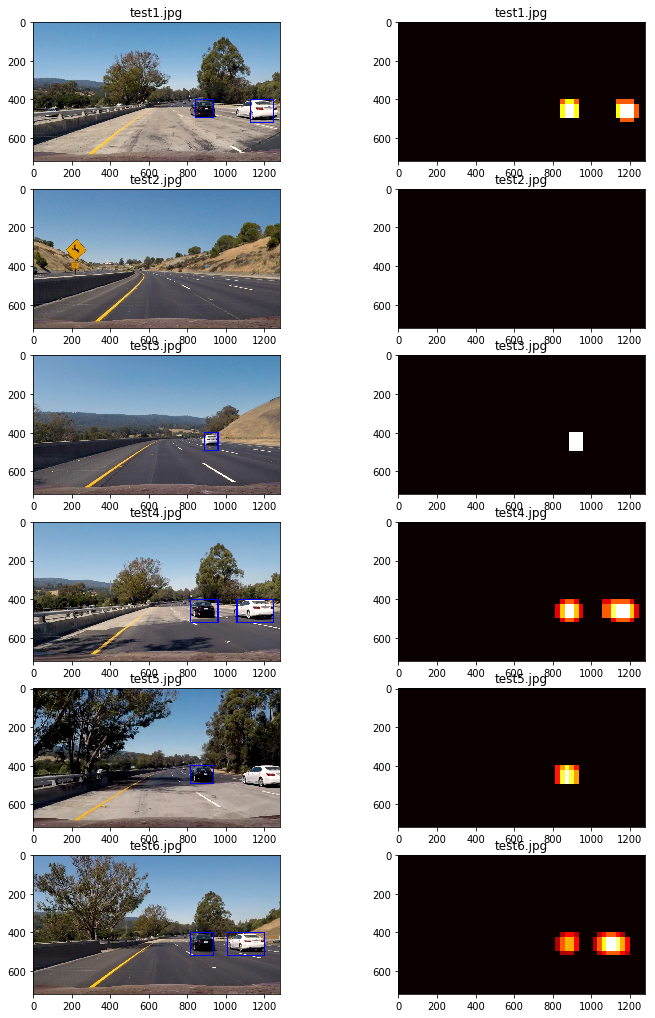

In [7]:
out_images = []
out_titles = []

for img_src in test_images:
    img = mpimg.imread(img_src)
    # Read in image similar to one shown above 
    #heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    out_img, heatmap, img_boxes, count = find_cars(img = img, scale = scale, clf = svc, scaler = x_scaler,
                                                   x_start_stop = x_start_stop, y_start_stop = y_start_stop,
                                                   orient = orient, pix_per_cell = pix_per_cell, 
                                                   cell_per_block = cell_per_block, spatial_size = spatial_size,
                                                   hist_bins = hist_bins)
    # Add heat to each box in box list
    #heat = add_heat(heat, img_boxes)
    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat, 1)
    heat = apply_threshold(heatmap, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    out_images.append(draw_img)
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])
    out_images.append(heatmap)

fig = plt.figure(figsize = (12, 24))
visual(fig, 8, 2, out_images, out_titles)
plt.savefig('output_images/heatmap_img.jpg')

## Video Processing

In [8]:
video_processing('test_video.mp4', 'output_videos/ouput_test_video.mp4', main_process)

[MoviePy] >>>> Building video output_videos/ouput_test_video.mp4
[MoviePy] Writing video output_videos/ouput_test_video.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:23<00:00,  1.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/ouput_test_video.mp4 

Wall time: 26.1 s


In [9]:
video_processing('project_video.mp4', 'output_videos/output_project_video.mp4', main_process)

[MoviePy] >>>> Building video output_videos/output_project_video.mp4
[MoviePy] Writing video output_videos/output_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [12:53<00:00,  1.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_project_video.mp4 

Wall time: 12min 55s


## Challenge

In [10]:
video_processing('test_video.mp4', 'output_videos/challenge_test_video.mp4', challenge)

[MoviePy] >>>> Building video output_videos/challenge_test_video.mp4
[MoviePy] Writing video output_videos/challenge_test_video.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:27<00:00,  1.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_test_video.mp4 

Wall time: 30.1 s


In [11]:
video_processing('project_video.mp4', 'output_videos/challenge_project_video.mp4', challenge)

[MoviePy] >>>> Building video output_videos/challenge_project_video.mp4
[MoviePy] Writing video output_videos/challenge_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [18:00<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_project_video.mp4 

Wall time: 18min 2s
